In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

train_df = pd.read_csv('train.csv')
#train_df.head()
print(train_df)

            id                        url  \
0            0                    m.kp.md   
1            1                  www.kp.by   
2            2              fanserials.tv   
3            3            colorbox.spb.ru   
4            4              tula-sport.ru   
...        ...                        ...   
135304  135304                    mail.ru   
135305  135305                 www.ntv.ru   
135306  135306  topclassiccarsforsale.com   
135307  135307                wowcream.ru   
135308  135308                 www.ubu.ru   

                                                    title  target  
0       Экс-министр экономики Молдовы - главе МИДЭИ, ц...   False  
1       Эта песня стала известна многим телезрителям б...   False  
2       Банши 4 сезон 2 серия Бремя красоты смотреть о...   False  
3                                   Не Беси Меня Картинки   False  
4       В Новомосковске сыграют следж-хоккеисты алекси...   False  
...                                                

In [2]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [3]:
train_df['target'].value_counts()

False    118594
True      16715
Name: target, dtype: int64

In [4]:
# Поглядим, какие есть уникальные url
unique_urls = train_df['url'].value_counts()
print(unique_urls)

mail.ru                    7900
baza.drom.ru               1042
www.olx.ua                  945
irecommend.ru               767
daftsex.com                 741
                           ... 
schalarmisli.ga               1
specm-group.ru                1
cxema.my1.ru                  1
www.culturavrn.ru             1
desenhosparacolorir.xyz       1
Name: url, Length: 40391, dtype: int64


In [5]:
# Для каждого рассчитываем процент положительных и отрицательных

# freq_urls = unique_urls[unique_urls > 10]
# freq_urls = unique_urls
# urls = []
# pos_ratios = []
# neg_ratios = []
# nums = []
# for url_i in freq_urls.index:
#     idxs = train_df['url'] == url_i
#     targets = train_df[idxs]['target']
#     n_true = targets[targets == 1].size
#     urls.append(url_i)
#     pos_ratios.append(n_true/targets.size)
#     neg_ratios.append(1 - n_true/targets.size)
#     nums.append(targets.size)

# url_info_df = pd.DataFrame({'url' : urls, 'pos_ratio' : pos_ratios, 'neg_ratio' : neg_ratios, 'num' : nums})
# url_info_df.to_csv('url_info.csv', index=False)
url_info_df = pd.read_csv('url_info.csv')

# А теперь вводим метрики, учитывающие количество появлений url
# Для этого будем умножать на сигмоиды
pos_sigm = url_info_df['pos_ratio'] * 1/(1 + 0.5*np.exp(-(url_info_df['num'] - 4)))
neg_sigm = url_info_df['neg_ratio'] * 1/(1 + 0.5*np.exp(-(url_info_df['num'] - 4)))
url_info_df['pos_sigm'] = pos_sigm
url_info_df['neg_sigm'] = neg_sigm
print(url_info_df)

                             url  pos_ratio  neg_ratio   num  pos_sigm  \
0                        mail.ru   0.016203   0.983797  7900  0.016203   
1                   baza.drom.ru   0.000000   1.000000  1042  0.000000   
2                     www.olx.ua   0.000000   1.000000   945  0.000000   
3                  irecommend.ru   0.000000   1.000000   767  0.000000   
4                    daftsex.com   1.000000   0.000000   741  1.000000   
...                          ...        ...        ...   ...       ...   
40386  dalnerechensk.bankiros.ru   0.000000   1.000000     1  0.000000   
40387               whatname.net   0.000000   1.000000     1  0.000000   
40388            makulatura57.ru   0.000000   1.000000     1  0.000000   
40389      www.chirana-russia.ru   0.000000   1.000000     1  0.000000   
40390               kam.kam24.ru   0.000000   1.000000     1  0.000000   

       neg_sigm  
0      0.983797  
1      1.000000  
2      1.000000  
3      1.000000  
4      0.000000  
...

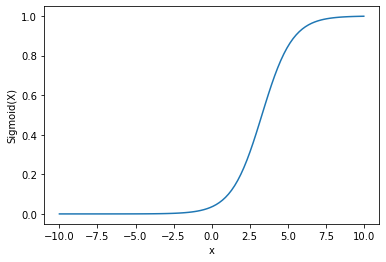

0.0353368440280961


In [6]:
# Если что, вот эта сигмоида
x = np.linspace(-10, 10, 100)
coef = 0.5
sigm = 1/(1 + coef*np.exp(-(x - 4)))
plt.plot(x, sigm) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)")
  
plt.show()
print(1/(1 + coef*np.exp(4)))

In [7]:
# Добавляем эти сигмоидные метрики в датафреймы
train_df_m = pd.merge(train_df, url_info_df, how='left',on=['url'])
test_df_m = pd.merge(test_df, url_info_df, how='left',on=['url'])
# Если такого url в test не было в train -- просто обнуляем
test_df_m = test_df_m.fillna(value=0.)
test_df_m.head()


,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...,0.0,1.0,10.0,0.000000,0.998762
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ...",0.0,1.0,6.0,0.000000,0.936621
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ...",1.0,0.0,1.0,0.090557,0.000000
4,135313,2gis.ru,67,0.0,1.0,75.0,0.000000,1.000000


In [8]:
# Теперь непосредственно обрабатываем тайтлы
# Всё в нижни регистр
train_df_m['title'] = train_df_m['title'].str.lower()
test_df_m['title'] = test_df_m['title'].str.lower()
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,шестой кассационный суд в самаре начнет работу...,0.0,1.0,10.0,0.000000,0.998762
1,135310,urexpert.online,"что такое индексация алиментов, кем и в каких ...",0.0,1.0,6.0,0.000000,0.936621
2,135311,imperimeha.ru,женщинам | империя меха - part 12,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,"небритые, волосатые киски: порно всех стран и ...",1.0,0.0,1.0,0.090557,0.000000
4,135313,2gis.ru,67,0.0,1.0,75.0,0.000000,1.000000


In [9]:
# Удаляем всё, что не буквы
train_df_m['title'] = train_df_m['title'].str.replace('[^a-zA-Zа-яА-Я ]', '')
test_df_m['title'] = test_df_m['title'].str.replace('[^a-zA-Zа-яА-Я ]', '')
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,шестой кассационный суд в самаре начнет работу...,0.0,1.0,10.0,0.000000,0.998762
1,135310,urexpert.online,что такое индексация алиментов кем и в каких с...,0.0,1.0,6.0,0.000000,0.936621
2,135311,imperimeha.ru,женщинам империя меха part,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,небритые волосатые киски порно всех стран и на...,1.0,0.0,1.0,0.090557,0.000000
4,135313,2gis.ru,,0.0,1.0,75.0,0.000000,1.000000


In [11]:
import pymorphy2

# Лемматизируем
lemmatizer = pymorphy2.MorphAnalyzer()

lemmatizer_cache = {}
def lem_text(text):
    return ' '.join([lem_token(token) for token in text.split()])

def lem_token(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

train_df_m['title'] = train_df_m['title'].apply(lem_text)
test_df_m['title'] = test_df_m['title'].apply(lem_text)
test_df_m.head()

In [13]:
# Сделаем лучше tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
train_titles_tfidf = tfidf_vectorizer.fit_transform(train_df_m['title'])
test_titles_tfidf = tfidf_vectorizer.transform(test_df_m['title'])
print(train_titles_tfidf.shape)
print(test_titles_tfidf.shape)

(135309, 133457)
(165378, 133457)


In [14]:
# Слепим данные
from scipy.sparse import coo_matrix, hstack

data_train = hstack([train_df_m.iloc[:,7:], train_titles_tfidf])
print(data_train.shape)

X_train, X_test, y_train, y_test = train_test_split(data_train, train_df_m['target'], test_size=0.2, random_state=42)
#y_train = y_train.astype(int).values
#y_test = y_test.astype(int).values
print(X_train.shape)

(135309, 133459)
(108247, 133459)


In [15]:
# Вот и чего б не обучить регрессию?
log_clf = LogisticRegression(random_state=42, max_iter=100).fit(X_train, y_train)
y_pred = log_clf.predict(X_test)
f1_score(y_test, y_pred)


0.9598399753808278

In [16]:
# А теперь лесок
rf_clf = RandomForestClassifier(random_state=42, n_estimators=10, n_jobs = 2).fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
f1_score(y_test, y_pred)

0.9902358419708577

In [18]:
# А теперь лесок с добавленными туда предсказаниями регрессии
train_log_prob = log_clf.predict_proba(X_train)[:,1]
test_log_prob = log_clf.predict_proba(X_test)[:,1]
X_train_log = hstack([X_train, np.transpose([train_log_prob])])
X_test_log = hstack([X_test, np.transpose([test_log_prob])])
rf_log_clf = RandomForestClassifier(random_state=42, n_estimators=10, n_jobs = 2).fit(X_train_log, y_train)
y_pred = rf_log_clf.predict(X_test_log)
f1_score(y_test, y_pred)

0.9900811541929666

In [ ]:
# Оставляем столько нулей, сколько есть единиц
def balance_data(data):
    true_idxs = np.arange(data.shape[0]) [data['target'] == True]
    false_idxs = np.arange(data.shape[0]) [data['target'] == False]
    print(true_idxs.size)
    random_false_idxs = np.random.choice(false_idxs, true_idxs.size, replace=False)
    temp = np.concatenate([true_idxs, random_false_idxs])
    random_idxs = np.random.choice(temp, temp.size, replace=False)
    return data.iloc[random_idxs]

In [ ]:
data_balanced = balance_data(data)
data_balanced['target'].value_counts()

In [ ]:
from sklearn.metrics import f1_score
X_train = train_df["title"].values
X_test = test_df["title"].values
y_train = train_df["target"].astype(int).values